In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from astropy.stats import sigma_clip
from datetime import datetime
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set()
from scipy.stats import norm
import pandas as pd
import warnings
import matplotlib.mlab as mlab
from pandas import DataFrame
import astropy
sns.set(style ='white')
import matplotlib.transforms as mtransforms
from scipy.optimize import curve_fit

In [2]:
pwd

'/home/jovyan/ASTR_136/Spectroscopy'

### MASTER BIAS

In [3]:
filedir = '/home/jovyan/ASTR_136/Spectroscopy/BIAS' 
files_bias = [os.path.join(filedir, f) for f in os.listdir(filedir)]

In [4]:
files_bias = files_bias[1:6]

In [5]:
def clip(x,mean,sigma,sigmafactor):
    cliplow = np.where(data <=(mean - sigmafactor * sigma))
    cliphigh = np.where(data >= (mean + sigmafactor * sigma))
    data[cliplow] = mean
    data[cliphigh] = mean
    return data

In [6]:
bias_data = []
bias_exp = []
    
for i in range(len(files_bias)):
    hdu = fits.open(files_bias[i])
    data = hdu[0].data[430:2500,90:360]
    biasdata_clipped = clip(data, np.nanmean(data), np.nanstd(data), 3)
    bias_data.append(biasdata_clipped)
    bias_exp.append(hdu[0].header['EXPTIME'])        


bias_data = np.stack(bias_data, axis=-1)

In [7]:
bias_data.shape

(2070, 270, 5)

In [8]:
bias_mean = np.mean(bias_data,axis=(0,1))
bias_median = np.median(bias_data,axis=(0,1))
bias_std = np.std(bias_data, axis = (0,1))
bias_counts = np.sum(bias_data, axis=(0,1))
bias_count_error = np.sqrt(bias_mean)

bias_master = np.median(bias_data, axis=2)

In [9]:
bias_master.shape

(2070, 270)

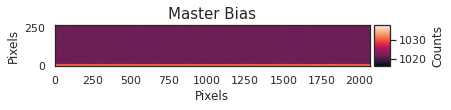

In [10]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(bias_master.T, origin = 'lower')
plt.title('Master Bias', loc= 'center', fontsize=15)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

### MASTER FLAT

In [11]:
filedir = '/home/jovyan/ASTR_136/Spectroscopy/FLAT'
files_flat= [os.path.join(filedir, f) for f in os.listdir(filedir) if f.endswith('.fits')]

In [12]:
files_flat

['/home/jovyan/ASTR_136/Spectroscopy/FLAT/r349.fits',
 '/home/jovyan/ASTR_136/Spectroscopy/FLAT/r351.fits',
 '/home/jovyan/ASTR_136/Spectroscopy/FLAT/r350.fits',
 '/home/jovyan/ASTR_136/Spectroscopy/FLAT/r352.fits']

In [13]:
flat_exp = []
flat_data = []

for i in range(len(files_flat)):
    hdu_flat = fits.open(files_flat[i])
    data = hdu_flat[0].data[430:2500,90:360]
    corr_flat = ((data - bias_master)/hdu_flat[0].header['EXPTIME'])
    flat_clipped = clip(corr_flat, np.nanmean(corr_flat), np.nanstd(corr_flat), 3)
    flat_min = np.min(flat_clipped)
    flat_norm = (flat_clipped / flat_min)
    flat_data.append(flat_norm)
    flat_exp.append(hdu_flat[0].header['EXPTIME'])

#flat_masks = [arr.mask for arr in flat_data] # Get masks for each image in flat_data
#flat_data = np.ma.masked_array(data=np.dstack(flat_data),
                                 #mask=np.dstack(flat_masks)) # Create stacked masked array

In [14]:
flat_data = np.array(flat_data)
flat_master = np.median(flat_data, axis = 0)

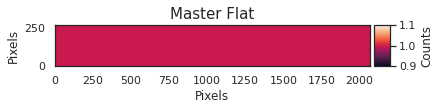

In [15]:
ax = plt.subplot(111)
im = ax.imshow(flat_master.T, origin = 'lower')
plt.title('Master Flat', loc= 'center', fontsize=15)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

### MASTER SCIENCE

In [16]:
filedir = '/home/jovyan/ASTR_136/Spectroscopy/SCI'
files_science = [os.path.join(filedir, f) for f in os.listdir(filedir)if f.endswith('.fits')]

In [17]:
science_data = []
for i in range(len(files_science)):
    hdu_sci = fits.open(files_science[i])
    header_sci = hdu_sci[0].header
    data = hdu_sci[0].data[430:2500,90:360]
    sci_clipped = clip(data, np.nanmean(data), np.nanstd(data), 3)
    correct_sci = (((sci_clipped - bias_master) / header_sci['EXPTIME'])) / flat_master
    science_data.append(correct_sci)


science_data = np.array(science_data)

In [18]:
science_master = np.median(science_data, axis = 0)
science_master = science_master.T

In [19]:
science_master.shape

(270, 2070)

In [20]:
science_master = science_master[0:240, 0:2048 ]

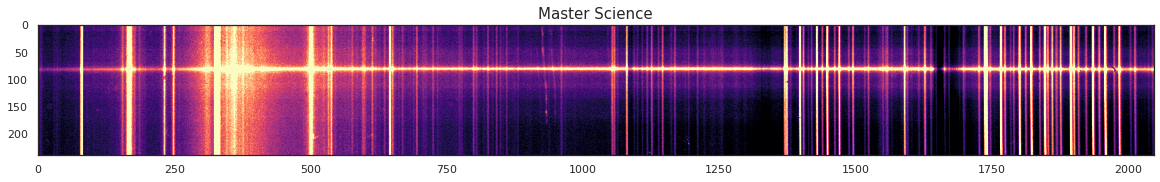

In [21]:
sns.set(style ='white')

plt.figure(figsize = (20,5))
plt.imshow(science_master, cmap = 'magma',vmin = np.percentile(science_master, 5),
           vmax = np.percentile(science_master, 95))
plt.title('Master Science', loc= 'center', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

In [22]:
science_master.shape

(240, 2048)

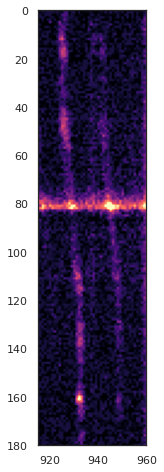

In [111]:
sns.set(style ='white')

plt.figure(figsize = (20,8))
plt.imshow(science_master, cmap = 'magma',vmin = np.percentile(science_master, 5),
           vmax = np.percentile(science_master, 95))
plt.xlim(915,960)
plt.ylim(180,0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

In [24]:
s_shape = science_master[0:180,915:960]

### BACKGROUND SUBTRACTION

In [25]:
sci_cut = science_master[200:280,0:2048]

In [26]:
columns = np.arange(0,2048,1)
fullrows = science_master[:,0]
rows = np.arange(0,40,1)

In [27]:
back = np.zeros_like(science_master)
for col in columns:
    poly =np.polyfit(rows, sci_cut[rows,col], 2)
    back[:, col] = np.polyval(poly, fullrows)

In [28]:
back_sub = science_master- back

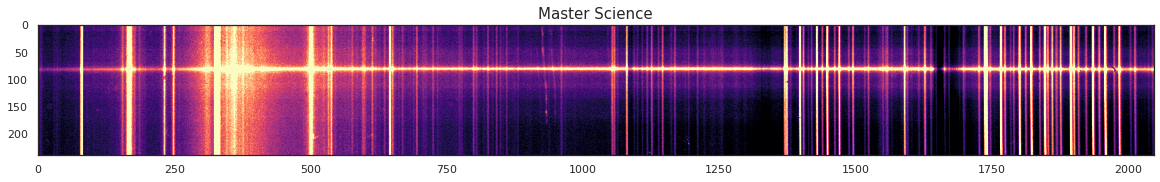

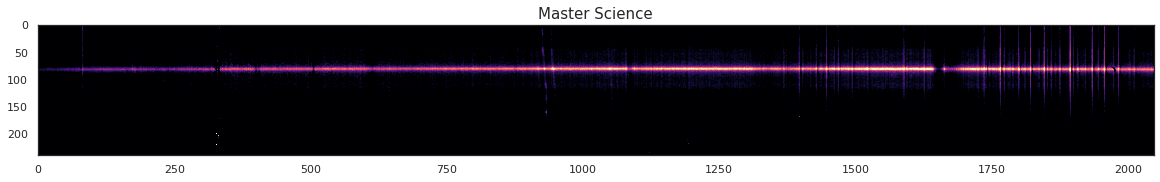

In [29]:
sns.set(style ='white')

plt.figure(figsize = (20,5))
plt.imshow(science_master, cmap = 'magma',vmin = np.percentile(science_master, 5),
           vmax = np.percentile(science_master, 95))
plt.title('Master Science', loc= 'center', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

sns.set(style ='white')

plt.figure(figsize = (20,5))
plt.imshow(back_sub, cmap = 'magma',vmin = np.percentile(science_master, 5),
           vmax = np.percentile(science_master, 95))
plt.title('Master Science', loc= 'center', fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

### ARC LAMP CALIBRATION

In [30]:
filedir = '/home/jovyan/ASTR_136/Spectroscopy/BIAS' 
files_bias = [os.path.join(filedir, f) for f in os.listdir(filedir)]

In [32]:
files_bias = files_bias[1:6]
bias_data = []
bias_exp = []
    
for i in range(len(files_bias)):
    hdu = fits.open(files_bias[i])
    data = hdu[0].data[452:2500,20:300]
    biasdata_clipped = clip(data, np.nanmean(data), np.nanstd(data), 3)
    bias_data.append(data)
    bias_exp.append(hdu[0].header['EXPTIME'])
    

bias_data = np.stack(bias_data, axis=-1)

In [33]:
bias_mean = np.mean(bias_data,axis=(0,1))
bias_median = np.median(bias_data,axis=(0,1))
bias_std = np.std(bias_data, axis = (0,1))
bias_counts = np.sum(bias_data, axis=(0,1))
bias_count_error = np.sqrt(bias_mean)

bias_master = np.median(bias_data, axis=2)

In [34]:
filedir = '/home/jovyan/ASTR_136/Spectroscopy/FLAT'
files_flat= [os.path.join(filedir, f) for f in os.listdir(filedir) if f.endswith('.fits')]

In [35]:
flat_exp = []
flat_data = []

for i in range(len(files_flat)):
    hdu_flat = fits.open(files_flat[i])
    corr_flat = ((hdu_flat[0].data[452:2500,20:300] - bias_master)/hdu_flat[0].header['EXPTIME'])
    flat_clipped = clip(corr_flat, np.nanmean(corr_flat), np.nanstd(corr_flat), 3)
    flat_min = np.min(flat_clipped)
    flat_norm = (flat_clipped / flat_min)
    flat_data.append(flat_norm)
    flat_exp.append(hdu_flat[0].header['EXPTIME'])

In [36]:
flat_data = np.array(flat_data)
flat_master = np.median(flat_data, axis = 0)

In [38]:
filedir =filedir = '/home/jovyan/ASTR_136/Spectroscopy/ARC'
files_ARC = [os.path.join(filedir, f) for f in os.listdir(filedir)if f.endswith('.fits')] 

In [43]:
ARC_data = []
for i in range(len(files_ARC)):
    hdu_ARC = fits.open(files_ARC[i])
    data = hdu_ARC[0].data[452:2500,20:300]
    header_ARC = hdu_ARC[0].header
    ARC_clipped = clip(data, np.nanmean(data), np.nanstd(data),2)
    correct_ARC = (((ARC_clipped - bias_master) / header_ARC['EXPTIME'])) / flat_master
    ARC_data.append(correct_ARC)

ARC_data = np.array(ARC_data)

In [44]:
ARC_master = np.median(ARC_data, axis = 0)
ARC = ARC_master.T

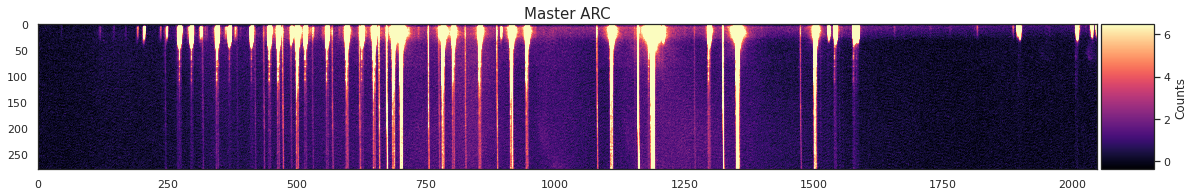

In [45]:
sns.set(style ='white')
plt.figure(figsize = (20,45))
ax = plt.subplot(111)
im = ax.imshow(ARC,cmap = 'magma',vmin = np.percentile(ARC, 5),
           vmax = np.percentile(ARC, 95))
plt.title('Master ARC', loc= 'center', fontsize=15)
#plt.xlabel('Pixels')
#plt.ylabel('Pixels')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

In [46]:
intensity = np.sum(ARC, axis = 0)
columns = np.arange(0,len(ARC[0,:]),1)

Text(0.5, 1.0, 'Arc-Lamp Spectrum')

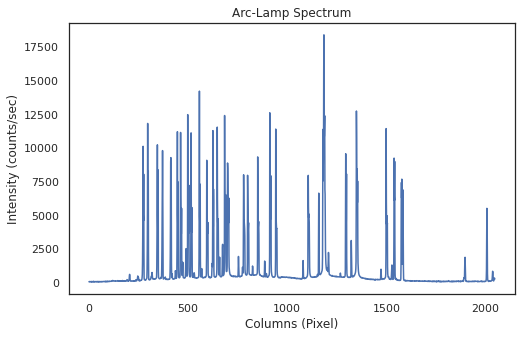

In [47]:
palette = sns.cubehelix_palette(4, start =1
                                ,rot=-.1)
plt.figure(figsize=(8,5))
sns.lineplot(columns,intensity, palette = palette)
plt.xlabel('Columns (Pixel)')
plt.ylabel('Intensity (counts/sec)')
plt.title('Arc-Lamp Spectrum')

In [49]:
def Gaussian_fit(x,sigma, mu, height): #sigma here = sigma^2
    return (np.exp(-0.5*((x-mu)**2/sigma))*height)

In [50]:
columns = np.arange(0,2048,1)

sigmas, mus, heights =[], [],[]
peaks = []
for i in range(len(columns)):
    if intensity[i] > np.percentile(intensity, 99):
        params = [3, i ,intensity[i]]
        parameters ,cov = curve_fit(Gaussian_fit, columns[i-4:i+4], intensity[i-4:i+4], p0 = params)
        peaks.append(i)
        sigmas.append(parameters[0])
        mus.append(parameters[1])
        heights.append(parameters[2])

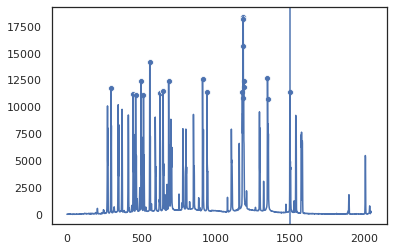

In [51]:
sns.lineplot(columns,intensity)
sns.scatterplot(columns[peaks],intensity[peaks])
plt.axvline(1502)
#plt.xlim(1000,1505)

In [294]:
wavelengths = 6402.25,6506.53,6678.2,6929.47,7032.41,7245.17,7438.90
peaks = 702,783,916,1108,1185,1350,1502

m, b = np.polyfit(peaks, wavelengths, 1 , full = False, cov = True)
print('spectral dispersion=',m)

spectral dispersion= [1.29925274e+00 5.48982412e+03]


In [308]:
m  = 1.29925274e+00
b = 5.48982412e+03

In [304]:
cov_m = np.sqrt(b[0,0]) #on m
cov_m

0.002768587434830694

In [306]:
cov_b = np.sqrt(b[1,1]) #on b
cov_b

3.078586353745144

In [53]:
def func(x,m,b):
    f = []
    for i in x:
        y_func = m*i + b
        f.append(y_func)
    return f

y_fit = func(peaks,m,b)

No handles with labels found to put in legend.


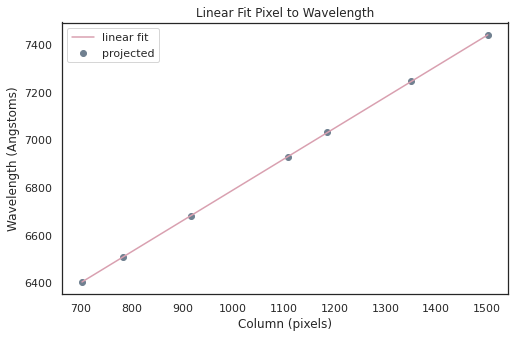

In [54]:
sns.set(style='white')
palette = sns.cubehelix_palette(4, start =1,rot=-.1,  dark=0.7, light=.95, reverse=True)
sns.set_palette(palette)

plt.figure(figsize=(8,5))
plt.xlabel('Column (pixels)') 
plt.ylabel('Wavelength (Angstoms)') 
plt.title('Linear Fit Pixel to Wavelength')
plt.scatter(peaks, wavelengths, label="projected" , color='slategray')
sns.lineplot(peaks, y_fit, label='linear fit', palette = palette)
#plt.savefig("Man.pdf")
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

### IDENTIFY H-ALPHA AND NII

In [57]:
bkgdata = np.concatenate((science_master[:, :20], science_master[:, -20:]), axis = 1)
bkgrow = np.median(bkgdata, axis = 1)
bkg = np.array([bkgrow,] *science_master.shape[1]).T
science_master -= bkg
science_master[np.where(science_master < 0)] = np.median(science_master)

In [62]:
columns = np.arange(0,2048,1)
flux = np.sum(science_master,axis = 0)
wave_func = func(columns,m,b)

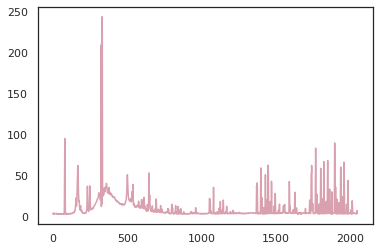

In [65]:
plt.plot(science_master.sum(0),)

In [74]:
intensity_blue = science_master[0:82, 915:960].sum(0)
columns_blue = wave_func[915:960]

In [75]:
sigmas, mus, heights =[], [],[]
peaks = []
for i in range(len(columns_blue)):
    if intensity_blue[i] > np.percentile(intensity_blue, 85):
        params = [3, i ,intensity_blue[i]]
        parameters ,cov = curve_fit(Gaussian_fit, columns_blue[i-4:i+4], intensity_blue[i-4:i+4], p0 = params)
        peaks.append(i)
        sigmas.append(parameters[0])
        mus.append(parameters[1])
        heights.append(parameters[2])
        


h_alpha_1 = columns_blue[11]
n_2_1 = columns_blue[27]

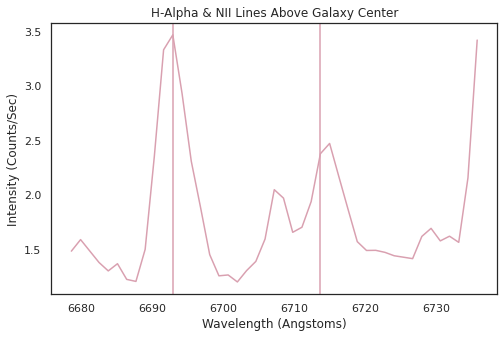

In [76]:
plt.figure(figsize=(8,5))
plt.xlabel('Wavelength (Angstoms)') 
plt.ylabel('Intensity (Counts/Sec)') 
plt.title('H-Alpha & NII Lines Above Galaxy Center')
sns.lineplot(columns_blue,intensity_blue)
plt.axvline(h_alpha_1)
plt.axvline(n_2_1)

In [80]:
intensity_red = science_master[82:, 915:960].sum(0)
columns_red = wave_func[915:960]

In [81]:
sigmas, mus, heights =[], [],[]
peaks = []
for i in range(len(columns_red)):
    if intensity_red[i] > np.percentile(intensity_red, 75):
        params = [3, i ,intensity_red[i]]
        parameters ,cov = curve_fit(Gaussian_fit, columns_red[i-4:i+4], intensity_red[i-4:i+4], p0 = params)
        peaks.append(i)
        sigmas.append(parameters[0])
        mus.append(parameters[1])
        heights.append(parameters[2])
        
h_alpha_2 = columns_red[17]
n_2_2 = columns_red[33]

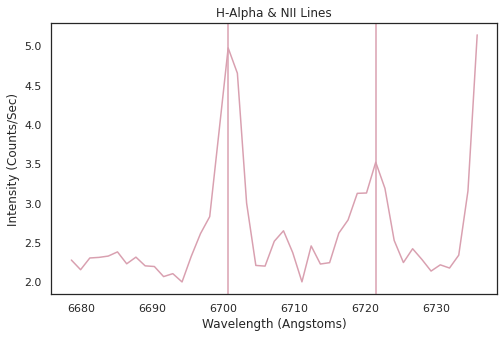

In [82]:
plt.figure(figsize=(8,5))
plt.xlabel('Wavelength (Angstoms)') 
plt.ylabel('Intensity (Counts/Sec)') 
plt.title('H-Alpha & NII Lines')
sns.lineplot(columns_red,intensity_red)
plt.axvline(h_alpha_2)
plt.axvline(n_2_2)

In [83]:
print(h_alpha_1)
print(h_alpha_2)

6692.932155347273
6700.727671771534


In [84]:
print(n_2_1)
print(n_2_2)

6713.720199145304
6721.515715569566


In [87]:
h_alpha_rest = 6562.801
n_2_rest = 6583.45

In [525]:
wave_obs = h_alpha_1, h_alpha_2 #redshift from h_alpha
wave_obs = np.array(wave_obs)
wave_rest = h_alpha_rest
redshift = wave_obs/wave_rest - 1

mean_halpha = np.mean(redshift)
mean_halpha

0.02042251678199647

In [526]:
wave_obs = n_2_1, n_2_2 #redshift from N2
wave_obs = np.array(wave_obs)
wave_rest = n_2_rest
redshift_2 = wave_obs/wave_rest - 1

mean_n2 = np.mean(redshift_2)
mean_n2

0.020379581732592356

In [96]:
means = mean_n2, mean_halpha
means = np.array(means)
redshift = np.mean(means) #mean of both redshifts

print('redshift = ', redshift)

redshift =  0.020401049257294412


In [97]:
difference_rest = (1+redshift)*(n_2_rest -h_alpha_rest) # difference in wavelength in rest frame
print('restframe difference=', difference_rest)

restframe difference= 21.07026126611329


In [98]:
difference_obs_r = (n_2_2-h_alpha_2) #difference in wavelength in observed frame for red shift
print('observed difference=', difference_obs_r)

observed difference= 20.78804379803205


In [99]:
difference_obs_b = (n_2_1-h_alpha_1) #difference in wavelength in observed frame for blue shift
print('observed difference=', difference_obs_b)

observed difference= 20.78804379803114


### FIND GALAXY CENTER

In [100]:
intensity = science_master.sum(1)
rows = np.arange(0,240,1)

In [101]:
len(intensity)

240

In [104]:
columns = np.arange(0,2048,1)

sigmas, mus, heights =[], [],[]
peaks = []
for i in range(len(rows)):
    if intensity[i] > np.percentile(intensity, 99):
        params = [3, i ,intensity[i]]
        parameters ,cov = curve_fit(Gaussian_fit, rows[i-4:i+4], intensity[i-4:i+4], p0 = params)
        peaks.append(i)
        sigmas.append(parameters[0])
        mus.append(parameters[1])
        heights.append(parameters[2])
        
peaks

[80, 81, 82]

Text(0.5, 1.0, 'Galaxy Center Pixel Location')

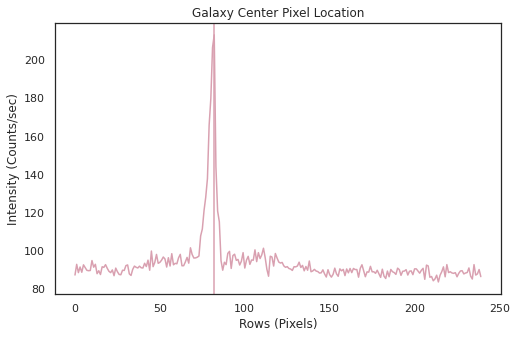

In [109]:
plt.figure(figsize = (8,5))
sns.lineplot(rows,intensity)
plt.axvline(rows[82])
plt.xlabel('Rows (Pixels)')
plt.ylabel('Intensity (Counts/sec)')
plt.title('Galaxy Center Pixel Location')

### ROTATION CURVE

In [110]:
def pixtokpc(pix): #pixel to radius
    return 74100*.43/3600*np.pi/180*pix

In [ ]:
columns_blue, intensity_blue
columns_red, wave_red

In [112]:
pixels_upper = np.arange(0,82,1)
pixels_lower = np.arange(0,-82,-1)

In [113]:
radius_upper = pixtokpc(pixels_upper)
radius_lower = pixtokpc(pixels_lower)

In [115]:
science_master.shape

(240, 2048)

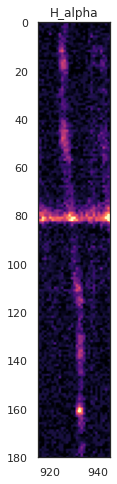

In [331]:
sns.set(style ='white')

plt.figure(figsize = (20,8))
plt.imshow(science_master, cmap = 'magma',vmin = np.percentile(science_master, 5),
           vmax = np.percentile(science_master, 95))
plt.xlim(915,945)
plt.ylim(180,0)
plt.title('H_alpha')
plt.show()

In [186]:
science_master.shape

(240, 2048)

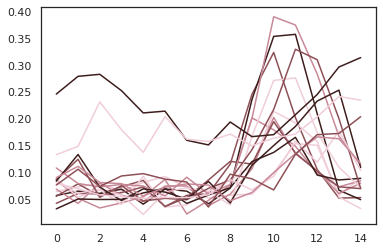

In [467]:
rows_upper = science_master[0:82,]

pixel_max = []
pixel_rad = []
pixel_std = []
for i in range(0,82,5):
    sci_cut = rows_upper[i:i+5, 915:930]
    radius_loc = 82- np.mean([i, i+5]) 
    spatial = np.sum(sci_cut,axis = 0)
    pixel_loc = list(spatial).index(np.max(spatial)) + 915
    px_std = (np.std(spatial[pixel_loc-910:pixel_loc+920]))/ np.sqrt(len(spatial[pixel_loc-910:pixel_loc+920]))
    plt.plot(spatial)
    pixel_max.append(pixel_loc)
    pixel_rad.append(radius_loc)
    pixel_std.append(px_std)

In [468]:
wave_pixel = func(pixel_max,m,b) #converting the pixels at h_alpha line to wavelenth
wave_pixel = np.array(wave_pixel)
pixel_rad = np.array(pixel_rad)

delta_lambda = np.abs(wave_pixel - h_alpha_rest)

In [419]:
c = 299792.458 #kilometers / second
velocity_h = ((delta_lambda/h_alpha_rest)*c) - redshift*c
radius_h = pixtokpc(pixel_rad)

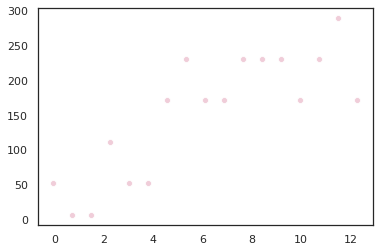

In [421]:
sns.scatterplot(radius_h.flatten(),np.abs(velocity_h))

In [271]:
science_master.shape

(240, 2048)

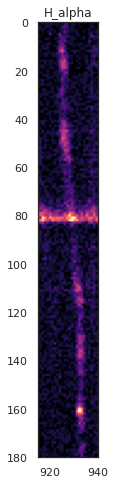

In [354]:
sns.set(style ='white')

plt.figure(figsize = (20,8))
plt.imshow(science_master, cmap = 'magma',vmin = np.percentile(science_master, 5),
           vmax = np.percentile(science_master, 95))
plt.xlim(915,940)
plt.ylim(180,0)
plt.title('H_alpha')
plt.show()

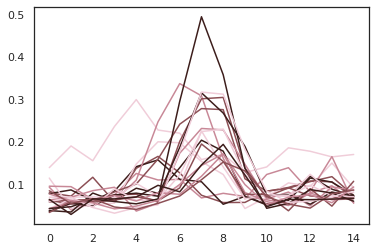

In [470]:
pixel_max_2 = []
pixel_rad_2 = []
pixel_std_2 = []
for i in range(82,180,5):
    sci_cut = science_master[i:i+5, 925:940]
    radius_loc = np.mean([i, i+5]) - 82
    spatial = np.sum(sci_cut,axis = 0)
    pixel_loc = list(spatial).index(np.max(spatial)) + 925
    px_std = (np.std(spatial[pixel_loc-920:pixel_loc+930]))/ np.sqrt(len(spatial[pixel_loc-920:pixel_loc+930]))
    plt.plot(spatial)
    pixel_max_2.append(pixel_loc)
    pixel_rad_2.append(radius_loc)
    pixel_std_2.append(px_std)

In [369]:
wave_pixel_lower = func(pixel_max_2,m,b) #converting the pixels at h_alpha line to wavelenth
wave_pixel_lower = np.array(wave_pixel_lower)
pixel_rad_lower = np.array(pixel_rad_2)

delta_lambda_lower = np.abs(wave_pixel_lower - h_alpha_rest)

In [416]:
c = 299792.458  #kilometers / second
velocity_h_l = ((delta_lambda_lower/h_alpha_rest)*c) - redshift*c
radius_h_l = pixtokpc(pixel_rad_lower)

No handles with labels found to put in legend.


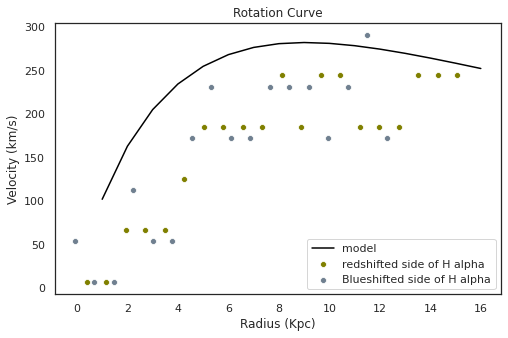

In [524]:
sns.set(style='white')
palette = sns.cubehelix_palette(4, start =1,rot=-.1, )
sns.set_palette(palette)


plt.figure(figsize=(8,5))
plt.xlabel('Radius (Kpc)') 
plt.ylabel('Velocity (km/s)') 
plt.title('Rotation Curve')
sns.scatterplot(radius_h_l.flatten(),np.abs(velocity_h_l), color='olive',hue_norm=(0, 7), label = 'redshifted side of H alpha')
#plt.errorbar(radius_h_l.flatten(),np.abs(velocity_h_l), color='olive',yerr= sigma_v_red,linestyle='none')
sns.scatterplot(radius_h.flatten(),np.abs(velocity_h),color = 'slategray', label='Blueshifted side of H alpha')
#plt.errorbar(radius_h.flatten(),np.abs(velocity_h), color='slategray',yerr= sigma_v_blue,linestyle='none')
sns.lineplot(R, model, color='black',label='model') 
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

In [494]:
len(velocity_h_l)

20

In [463]:
from scipy.special import iv, kn
def rotcurv(R, Rd, Mstar):
    pi = np.pi
    G = 4.3*10**-6 #kpc * Msun* k(m/s)^2
    sigma_0 = Mstar/(2*pi*Rd**2) 
    y = R/(2*Rd)
    v_squared = 4*pi*G* sigma_0* Rd* y**2 * (iv(0,y)*kn(0,y) -
                                             iv(1,y)*kn(1,y))
    v = abs(np.sqrt(v_squared))
    return v

Rd = 4.2 #kpc
Mstar = 200.0*10**9 #10^9 Msun
R = np.arange(0,17,1)
model = rotcurv(R, Rd, Mstar)
#plt.ylim(0,0.3)

In [478]:
c = 2.99e5 # (km/s)
m = 1.299  # (angstroms/pixel)
b = 5.490e3 # (angstroms)
sigma_m = 2.768e-3 # angstroms/pixels
sigma_b = 3.079 # angstroms
lambda_0 = 6562.8 # angstroms

In [520]:
def var(Px, sigma_Px):
    return np.sqrt(((c*Px)/(lambda_0)**2)*(sigma_m**2) + 
                      ((c*m)/(lambda_0)**2)*(sigma_Px**2)+((c/lambda_0)**2)*(sigma_b**2))
# Px = pixel value
# sigma_Px = pixel variance

In [485]:
a = np.arange(0,6,1)
x = np.arange(0,6,1)

test = var(a,x)

In [490]:
pixel_max_2 = np.array(pixel_max_2)
pixel_std_2 = np.array(pixel_std_2)

In [521]:
sigma_v_red = var(pixel_max_2,pixel_std_2)

In [522]:
sigma_v_red

array([140.2786922 , 140.2786922 , 140.2786922 , 140.2786922 ,
       140.2786922 , 140.27869221, 140.2786922 , 140.2786922 ,
       140.2786922 , 140.2786922 , 140.2786922 , 140.2786922 ,
       140.2786922 , 140.2786922 , 140.2786922 , 140.2786922 ,
       140.2786922 , 140.2786922 , 140.2786922 , 140.2786922 ])

In [501]:
pixel_max = np.array(pixel_max)
pixel_std = np.array(pixel_std)

In [502]:
sigma_v_blue = var(pixel_max,pixel_std)

In [507]:
def var1(Px, sigma_Px):
    return np.sqrt((sigma_m/m)**2 + (sigma_Px/Px)**2
                     + (sigma_b)**2)

In [511]:
sigma_v_red_1 = var1(pixel_max_2,pixel_std_2)

In [516]:
pixel_max_2

array([929, 929, 930, 930, 930, 931, 932, 932, 932, 932, 933, 932, 933,
       933, 932, 932, 932, 933, 933, 933])

In [512]:
sigma_v_red_1

array([3.07900074, 3.07900074, 3.07900074, 3.07900074, 3.07900074,
       3.07900074, 3.07900074, 3.07900074, 3.07900074, 3.07900074,
       3.07900074, 3.07900074, 3.07900074, 3.07900074, 3.07900074,
       3.07900074, 3.07900074, 3.07900074, 3.07900074, 3.07900074])